This code demonstrates an example of oversmoothing for the Graph Representation Learning Mini-project and is built from code from Practical 4

In [1]:
!pip install torch==1.12.0+cu113 torchvision==0.13.0+cu113 torchtext==0.13.0 torchaudio==0.12.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |██████████████▌                 | 834.1 MB 1.2 MB/s eta 0:13:35tcmalloc: large alloc 1147494400 bytes == 0x38cf6000 @  0x7fb88b487615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |██████████████████▍             | 1055.7 MB 1.6 MB/s eta 0:08:07tcmalloc: large alloc 1434370048 bytes == 0x7d34c000 @  0x7fb88b487615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |█████

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
import torch
import os
import typing
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.datasets as datasets

device = "cuda" if torch.cuda.is_available() else "cpu"

from torch_geometric.nn import GCNConv

In [ ]:
dataset = datasets.Planetoid(
    root="./",
    name='Cora',
    split="public",
    transform=torch_geometric.transforms.GCNNorm()
  )
print(dataset.data)

In [ ]:
class GCN(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hid_dim: int,
      n_classes: int,
      n_layers: int,
      dropout_ratio: float = 0.3):
    super(GCN, self).__init__()
    """
    Args:
      input_dim: input feature dimension
      hid_dim: hidden feature dimension
      n_classes: number of target classes
      n_layers: number of layers
      dropout_ratio: dropout_ratio
    """
    self.dropout=nn.Dropout(p=dropout_ratio)
    if n_layers==0:
        layers=[]
        self.end=nn.Linear(input_dim,n_classes)
    else:
        layer=nn.Linear(input_dim,hid_dim)
        layers=[layer]
        for j in range(1,n_layers):
            layer=nn.Linear(hid_dim,hid_dim)
            layers.append(layer)
        self.end=nn.Linear(hid_dim,n_classes)
    self.layers=nn.ModuleList(layers)
    self.LL=nn.LogSoftmax(dim=1)
    self.act=nn.ReLU()

  def forward(self, X, A) -> torch.Tensor:
    x=self.generate_node_embeddings(X,A)
    x=self.end(x)
    return self.LL(x)

  def generate_node_embeddings(self, X, A) -> torch.Tensor:
    x=X
    n=len(x)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    i=torch.eye(n).to(device)
    a=A+i
    d=torch.diag(torch.sum(A,dim=1))+i
    d=torch.inverse(torch.sqrt(d))
    a=torch.matmul(d,torch.matmul(a,d))
    for layer in self.layers:
        x=torch.matmul(a,x)
        x=layer(x)
        x=self.act(x)
        x=self.dropout(x)
    return x
  
  def param_init(self):
    for layer in self.layers:
        nn.init.xavier_uniform_(layer.weight)
    nn.init.xavier_uniform_(self.end.weight)

In [ ]:
def early_stop(acc,k):
    #Stop early when the best validation accuracy didn't occur in the last k epochs
    if len(acc)<=k:
        return False
    if max(acc[:-k])>=max(acc[-k:]):
        return True
    return False

In [ ]:
def edge_index_to_adj(ei,n):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    v=torch.Tensor([1]*len(ei[0])).to(device)
    return torch.sparse_coo_tensor(ei,v,(n,n)).to_dense()

In [ ]:

path="model_state"

def train(
    params: typing.Dict
) -> torch.nn.Module:
    """
    This function trains a node classification model and returns the trained model object.
    """
    # set device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # load dataset
    data = dataset.data
    data = data.to(device)

    # Update parameters
    params["n_classes"] = dataset.num_classes # number of target classes
    params["input_dim"] = dataset.num_features # size of input features

  # Set a model
    if params['model_name'] == 'GCN':
        model = GCN(
            params["input_dim"], 
            params["hid_dim"],
            params["n_classes"],
            params["n_layers"]
        ).to(device)
    elif params['model_name'] == 'SkipGCN':
        model = SkipGCN(
            params["input_dim"], 
            params["hid_dim"],
            params["n_classes"],
            params["n_layers"]
        ).to(device)
    elif params['model_name'] == 'JumpKnowGCN':
        model = JumpKnowGCN(
            params["input_dim"], 
            params["hid_dim"],
            params["n_classes"],
            params["n_layers"]
        ).to(device)
    else:
        raise NotImplementedError
    model.param_init()
    torch.save(model.state_dict(),path)
    best_seen=0
    n=len(data.x)
    A=edge_index_to_adj(data.edge_index,n)
    k=params["max_patience"]
    val_acc=[evaluate(model,data,data.val_mask)]
    loss_fn=nn.NLLLoss()
    optimizer=torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["weight_decay"])
    for epoch in range(params["epochs"]):
        model.train()
        y=model(data.x,A)
        loss=loss_fn(y[data.train_mask],data.y[data.train_mask])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        temp1=evaluate(model,data,data.val_mask)
        val_acc.append(temp1)
        if temp1>best_seen:
            best_seen=temp1
            torch.save(model.state_dict(),path)
        print("Epoch: ",epoch+1," Loss: ",loss.item()," Validation accuracy: ",val_acc[-1])
        if early_stop(val_acc,k):
            print("Early stopped at epoch ",epoch+1)
            break
    print("Best validation accuracy: ",max(val_acc))
    model.load_state_dict(torch.load(path))
    return model

In [ ]:

def convert_to_class_label(x):
    temp=x
    max_seen=temp[0]
    index=0
    for i in range(len(x)):
        if temp[i]>max_seen:
           max_seen=temp[i]
           index=i
    return index

In [ ]:
def evaluate(
    model,
    data,
    mask
):
    model.eval()
    n=len(data.x)
    A=edge_index_to_adj(data.edge_index,n)
    y=model(data.x,A)
    correct=0
    total=len(data.y[mask])
    for i in range(total):
        if convert_to_class_label(y[mask][i])==data.y[mask][i]:
            correct+=1
    return correct/total

In [ ]:
training_params = {
    "lr": 0.005,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 100,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": None, # number of layers
    "model_name": "GCN"
}

In [ ]:
training_params["n_layers"] = 0
model_0_layer = train(training_params)
training_params["n_layers"] = 1
model_1_layer = train(training_params)
training_params["n_layers"] = 2
model_2_layer = train(training_params)
training_params["n_layers"] = 3
model_3_layer = train(training_params)
training_params["n_layers"] = 5
model_5_layer = train(training_params)
training_params["n_layers"] = 10
model_10_layer = train(training_params)

Epoch:  1  Loss:  1.955048680305481  Validation accuracy:  0.164
Epoch:  2  Loss:  1.8523856401443481  Validation accuracy:  0.198
Epoch:  3  Loss:  1.752312421798706  Validation accuracy:  0.262
Epoch:  4  Loss:  1.6550545692443848  Validation accuracy:  0.312
Epoch:  5  Loss:  1.5608330965042114  Validation accuracy:  0.354
Epoch:  6  Loss:  1.4698593616485596  Validation accuracy:  0.386
Epoch:  7  Loss:  1.3823320865631104  Validation accuracy:  0.404
Epoch:  8  Loss:  1.2984333038330078  Validation accuracy:  0.41
Epoch:  9  Loss:  1.218320369720459  Validation accuracy:  0.43
Epoch:  10  Loss:  1.1421204805374146  Validation accuracy:  0.442
Epoch:  11  Loss:  1.069925308227539  Validation accuracy:  0.446
Epoch:  12  Loss:  1.0017869472503662  Validation accuracy:  0.454
Epoch:  13  Loss:  0.9377153515815735  Validation accuracy:  0.454
Epoch:  14  Loss:  0.8776785731315613  Validation accuracy:  0.466
Epoch:  15  Loss:  0.8216047286987305  Validation accuracy:  0.47
Epoch:  16 

In [ ]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,4)

from sklearn.manifold import TSNE
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:

import numpy as np

def dimension_reduction(model: nn.Module) -> pd.DataFrame:
    """
    Args:
      model: model object for generating features
    
    Return:
      pd.DataFrame: A data frame that has 'dimension 1', 'dimension 2', and 'labels' as a column
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    data = dataset.data
    data = data.to(device)

    node_embeddings=model(data.x,edge_index_to_adj(dataset.data.edge_index,len(data.x))).cpu()
    data=data.cpu()
    reduced_dim=TSNE().fit_transform(node_embeddings[data.val_mask].detach().numpy(),data.y[data.val_mask].detach().numpy())
    col_data=reduced_dim
    col_data=np.c_[col_data,data.y[data.val_mask].detach().numpy()]
    return pd.DataFrame(col_data,columns=["dimension 1","dimension 2","labels"])

In [ ]:
feature_dict = {
    "0_layer": dimension_reduction(model_0_layer),
    "1_layer": dimension_reduction(model_1_layer),
    "2_layer": dimension_reduction(model_2_layer),
    "3_layer": dimension_reduction(model_3_layer),
    "5_layer": dimension_reduction(model_5_layer),
    "10_layer": dimension_reduction(model_10_layer),
}

In [ ]:
def visualise(feature_dict: typing.Dict,n_rows=2,save=None) -> None:
    n_cols=len(feature_dict)//n_rows 
    fig,axs=plt.subplots(n_rows,n_cols)
    fig.set_size_inches(2*n_cols,2*n_rows)
    if n_rows>1:
        axs=np.concatenate([ax for ax in axs],axis=0)
    for i in range(len(feature_dict)):
        ax=axs[i]
        title=list(feature_dict)[i]
        data=feature_dict[title]
        ax.set_title(title)
        ax.scatter(data.loc[:,'dimension 1'],data.loc[:,'dimension 2'],c=data.loc[:,'labels'],s=2)
    if save is not None:
        fig.savefig(save)

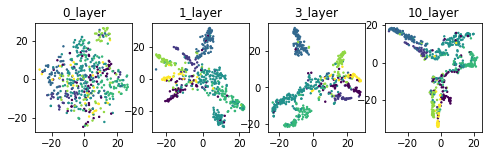

In [ ]:
feature_dict2={}
for key in ["0_layer","1_layer","3_layer","10_layer"]:
    feature_dict2[key]=feature_dict[key]
visualise(feature_dict2,1,"Q1a.jpg")

In [ ]:
from google.colab import files
files.download("Q1a.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
class SkipGCN(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hid_dim: int,
      n_classes: int,
      n_layers: int,
      dropout_ratio: float = 0.3):
    super(SkipGCN, self).__init__()
    """
    Args:
      input_dim: input feature dimension
      hid_dim: hidden feature dimension
      n_classes: number of target classes
      n_layers: number of layers
    """

    ## ------ Begin Solution ------ ##
    self.dropout=nn.Dropout(p=dropout_ratio)
    if n_layers==0:
        layers=[]
        self.end=nn.Linear(input_dim,n_classes)
    else:
        layer=nn.Linear(input_dim,hid_dim)
        layers=[layer]
        for j in range(1,n_layers):
            layer=nn.Linear(hid_dim,hid_dim)
            layers.append(layer)
        self.end=nn.Linear(hid_dim,n_classes)
    self.layers=nn.ModuleList(layers)
    self.LL=nn.LogSoftmax(dim=1)
    self.act=nn.ReLU()
    self.res_weight=nn.Linear(input_dim,hid_dim)
    ## ------ End Solution ------ ##

  def forward(self, X, A) -> torch.Tensor:
    x=self.generate_node_embeddings(X,A)
    x=self.end(x)
    return self.LL(x)

  def generate_node_embeddings(self, X, A) -> torch.Tensor:
    if len(self.layers)==0:
        return X
    x=X
    n=len(x)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    i=torch.eye(n).to(device)
    a=A+i
    d=torch.diag(torch.sum(A,dim=1))+i
    d=torch.inverse(torch.sqrt(d))
    a=torch.matmul(d,torch.matmul(a,d))
    temp=x
    x=torch.matmul(a,x)
    x=self.layers[0](x)
    x=self.act(x)
    x=x+self.res_weight(temp)
    x=self.dropout(x)
    for layer in self.layers[1:]:
        temp=x
        x=torch.matmul(a,x)
        x=layer(x)
        x=self.act(x)
        x=x+temp
        x=self.dropout(x)
    return x
  
  def param_init(self):
    for layer in self.layers:
        nn.init.xavier_uniform_(layer.weight)
    nn.init.xavier_uniform_(self.end.weight)
    nn.init.xavier_uniform_(self.res_weight.weight)

In [ ]:
training_params['model_name'] = 'SkipGCN'

training_params["n_layers"] = 0
model_0_layer = train(training_params)

training_params["n_layers"] = 1
model_1_layer = train(training_params)

training_params["n_layers"] = 3
model_3_layer = train(training_params)

training_params["n_layers"] = 10
model_10_layer = train(training_params)

Epoch:  1  Loss:  1.9542299509048462  Validation accuracy:  0.192
Epoch:  2  Loss:  1.851749300956726  Validation accuracy:  0.228
Epoch:  3  Loss:  1.7518199682235718  Validation accuracy:  0.244
Epoch:  4  Loss:  1.6546721458435059  Validation accuracy:  0.284
Epoch:  5  Loss:  1.5605348348617554  Validation accuracy:  0.312
Epoch:  6  Loss:  1.4696276187896729  Validation accuracy:  0.338
Epoch:  7  Loss:  1.3821576833724976  Validation accuracy:  0.364
Epoch:  8  Loss:  1.2983143329620361  Validation accuracy:  0.376
Epoch:  9  Loss:  1.218261480331421  Validation accuracy:  0.394
Epoch:  10  Loss:  1.142130970954895  Validation accuracy:  0.414
Epoch:  11  Loss:  1.07001531124115  Validation accuracy:  0.43
Epoch:  12  Loss:  1.0019663572311401  Validation accuracy:  0.448
Epoch:  13  Loss:  0.9379904866218567  Validation accuracy:  0.46
Epoch:  14  Loss:  0.8780531883239746  Validation accuracy:  0.472
Epoch:  15  Loss:  0.8220791220664978  Validation accuracy:  0.474
Epoch:  16 

In [ ]:
feature_dict = {
    "0_layer": dimension_reduction(model_0_layer),
    "1_layer": dimension_reduction(model_1_layer),
    "3_layer": dimension_reduction(model_3_layer),
    "10_layer": dimension_reduction(model_10_layer),
}

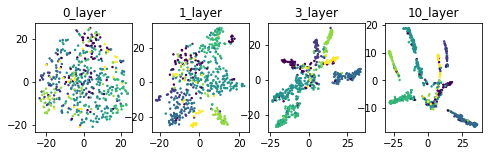

In [ ]:
visualise(feature_dict,1,"GRLQ1c.png")

In [ ]:
from google.colab import files
files.download("GRLQ1c.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>